# Установка приоритетов в списке гипотез и анализ результатов А/В теста

**Заказчик** - отдел маркетинга крупного интернет-магазина.

**Цель 1** - установить приоритеты в списке гипотез для увеличения выручки.<br>
**Цель 2** - проанализировать результаты А/В теста.

**Входные данные** - в нашем распоряжении 3 датасета: список гипотез, заказы  и посетители.

**Часть 1. Ход исследования**
1. Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.
2. Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.
3. Укажем, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясним, почему так произошло.

**Часть 2. Ход исследования**
1. Построим график кумулятивной выручки по группам.
2. Построим график кумулятивного среднего чека по группам.
3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A.
4. Построим график кумулятивной конверсии по группам.
5. Построим график относительного изменения кумулятивной конверсии группы B к группе A.
6. Построим точечный график количества заказов по пользователям.
7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.
8. Построем точечный график стоимостей заказов.
9. Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.
10. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.
11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.
12. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.
13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.
14. Примем решение по результатам теста и объясним его.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns

from scipy import stats as st
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 210

# Загрузим данные из датасетов

In [2]:
# Чтение файлов с данными и их сохранение
try:
    hypothesis, orders, visitors = (
        pd.read_csv('./datasets/hypothesis.csv'),
        pd.read_csv('./datasets/orders.csv'),
        pd.read_csv('./datasets/visitors.csv')
    )
    print('Данные загружены локально')
except:
    hypothesis, orders, visitors = (
        pd.read_csv('https://**************/hypothesis.csv'),
        pd.read_csv('https://**************/orders.csv'),
        pd.read_csv('https://**************/visitors.csv')
    )
    print('Данные загружены с сервера **************')
display(hypothesis.head(3))
display(orders.head(3))
display(visitors.head(3))

Данные загружены локально


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


In [3]:
# Пропуски, нули, уникальные и повторы
def info2(df):
    N = df.shape[0]
    C = df.shape[1]
    print(f'{N} - количество строк')
    print(f'{C} - количество колонок')
    
    col = df.columns.to_list()
    col.insert(0,'feature')
    result = pd.DataFrame(columns=col)
    
    result['feature'] = ['пропуски, шт', 'пропуски, %',
                         'нули, шт','нули, %',
                         'уникальные, шт','уникальные, %',
                         'повторы, шт','повторы, %']
    
    for column in col[1:]:
        result.loc[0, column] = len(df[df[column].isna() == True])
        result.loc[1, column] = round(len(df[df[column].isna() == True])/N*100,2)
        
        result.loc[2, column] = len(df[df[column] == 0])
        result.loc[3, column] = round(len(df[df[column] == 0])/N*100,2)
        
        result.loc[4, column] = len(df[column].unique())
        result.loc[5, column] = round(len(df[column].unique())/N*100,2)
        
        result.loc[6, column] = N - len(df[column].unique())
        result.loc[7, column] = round((N - len(df[column].unique()))/N*100,2)
    
    display(result)

# Часть 1. Приоритизация гипотез

Таблица hypothesis (список гипотез):
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.

In [4]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


**ICE**

Применим фреймворк ICE для приоритизации гипотез.<br>
Отсортируем их по убыванию приоритета.

In [5]:
hypothesis['ICE'] = (
    hypothesis['Impact']
    * hypothesis['Confidence']
    / hypothesis['Efforts']
)
ICE = hypothesis[['Hypothesis','ICE']]
ICE['ICE'] = round(ICE['ICE'], 3)
ICE.sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


В приоритете гипотезы с индексами: 8, 0 и 7.
Гипотеза *8. Запустить акцию, дающую скидку на товар в день рождения* лидер приоритизации ICE.

**RICE**

Применим фреймворк RICE для приоритизации гипотез.<br>
Отсортируем их по убыванию приоритета.

In [6]:
hypothesis['RICE'] = (
    hypothesis['Reach']
    * hypothesis['Impact']
    * hypothesis['Confidence']) / hypothesis['Efforts']

RICE = hypothesis[['Hypothesis','RICE']]
RICE.sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [7]:
ICE.merge(RICE).sort_values(by=['RICE', 'ICE'], ascending=False)

,Hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000,3.0


В приоритете гипотезы с индексами: 7, 2 и 0. При этом, значение RICE для гипотезы с индексом 7 вдвое выше, чем для гипотезы с индексом 2.

Применяя RICE, приоретизация учитывает (множитель Reach) скольких пользователей затронет изменение, которое хотим внести.

Для гипотезы: *7. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок* охват имеет особенное значение, поэтому такой отрыв от следующей гипотезы *2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа*.

# Часть 2. Анализ A/B-теста

## Проверим данные датасета orders
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

In [8]:
orders.sample(5)

,transactionId,visitorId,date,revenue,group
52,854249928,2570444314,2019-08-16,400,B
617,2150972893,1229532929,2019-08-07,6990,A
962,3024416906,530257481,2019-08-10,19260,B
1178,4052155355,2949041841,2019-08-14,190,A
622,2148936881,654930236,2019-08-29,19280,B


In [9]:
info2(orders)

1197 - количество строк
5 - количество колонок


,feature,transactionId,visitorId,date,revenue,group
0,"пропуски, шт",0,0,0,0,0
1,"пропуски, %",0.0,0.0,0.0,0.0,0.0
2,"нули, шт",0,0,0,0,0
3,"нули, %",0.0,0.0,0.0,0.0,0.0
4,"уникальные, шт",1197,1031,31,713,2
5,"уникальные, %",100.0,86.13,2.59,59.57,0.17
6,"повторы, шт",0,166,1166,484,1195
7,"повторы, %",0.0,13.87,97.41,40.43,99.83


Количество дубликатов

In [10]:
orders.duplicated().sum()

0

In [11]:
orders.describe(include='all')

,transactionId,visitorId,date,revenue,group
count,1.197000e+03,1.197000e+03,1197,1.197000e+03,1197
unique,NaN,NaN,31,NaN,2
top,NaN,NaN,2019-08-05,NaN,B
freq,NaN,NaN,48,NaN,640
mean,2.155621e+09,2.165960e+09,NaN,8.348006e+03,NaN
std,1.229085e+09,1.236014e+09,NaN,3.919113e+04,NaN
min,1.062393e+06,5.114589e+06,NaN,5.000000e+01,NaN
25%,1.166776e+09,1.111826e+09,NaN,1.220000e+03,NaN
50%,2.145194e+09,2.217985e+09,NaN,2.978000e+03,NaN
75%,3.237740e+09,3.177606e+09,NaN,8.290000e+03,NaN


Приведём к типам:
- `transactionId` — тип int64 не меняем;
- `visitorId` — тип int64 не меняем;
- `date` — диапазон 01.08.2019 - 31.08.2019, приведём к типу `datetime64[ns]`;
- `revenue` — денежные единицы, приведём к типу float;
- `group` — тип object не меняем.

In [12]:
orders['date'] = pd.to_datetime(orders['date'])
orders['revenue'] = orders['revenue'].astype('float')

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


## Проверим данные датасета visitors
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

In [13]:
visitors.sample(5)

,date,group,visitors
57,2019-08-27,B,720
33,2019-08-03,B,509
38,2019-08-08,B,654
39,2019-08-09,B,610
30,2019-08-31,A,699


In [14]:
info2(visitors)

62 - количество строк
3 - количество колонок


,feature,date,group,visitors
0,"пропуски, шт",0,0,0
1,"пропуски, %",0.0,0.0,0.0
2,"нули, шт",0,0,0
3,"нули, %",0.0,0.0,0.0
4,"уникальные, шт",31,2,58
5,"уникальные, %",50.0,3.23,93.55
6,"повторы, шт",31,60,4
7,"повторы, %",50.0,96.77,6.45


Количество дубликатов

In [15]:
visitors.duplicated().sum()

0

In [16]:
visitors.describe(include='all')

,date,group,visitors
count,62,62,62.000000
unique,31,2,NaN
top,2019-08-01,A,NaN
freq,2,31,NaN
mean,NaN,NaN,607.290323
std,NaN,NaN,114.400560
min,NaN,NaN,361.000000
25%,NaN,NaN,534.000000
50%,NaN,NaN,624.500000
75%,NaN,NaN,710.500000


Приведём к типам:
- `date` — диапазон 01.08.2019 - 31.08.2019, приведём к типу `datetime64[ns]`;
- `group` — тип object не меняем;
- `visitors` — диапазон 361 - 770, приведём к типу `uint16`.

In [17]:
visitors['date'] = pd.to_datetime(visitors['date'])
visitors['visitors'] = visitors['visitors'].astype('uint16')

visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     uint16        
dtypes: datetime64[ns](1), object(1), uint16(1)
memory usage: 1.2+ KB


# Построим таблицу data

- `date` — дата;
- `ordersPerDateA` — количество заказов в выбранную дату в группе A;
- `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
- `ordersPerDateB` — количество заказов в выбранную дату в группе B;
- `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
- `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
- `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
- `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
- `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
- `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
- `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

Подтвердим количество групп в А/Б тесте.

In [18]:
print('Группы в таблице orders:', sorted(orders['group'].unique()))
print('Группы в таблице visitors:', sorted(visitors['group'].unique()))

Группы в таблице orders: ['A', 'B']
Группы в таблице visitors: ['A', 'B']


Количество групп в таблицах orders и visitors, а так же названия этих групп совпадает.

Посмотрим на распределение количества пользователей в каждой группе.

In [19]:
v_info = visitors.groupby('group').agg({'visitors':'sum'}).reset_index()
v_info['delta_percent'] = (
    round(v_info['visitors'] /
    float(v_info[v_info['group']=='A']['visitors']) * 100, 2) - 100
)

o_info = orders.groupby('group').agg({'visitorId':'nunique'}).reset_index()
o_info['delta_percent'] = (
    round(o_info['visitorId'] /
    float(o_info[o_info['group']=='A']['visitorId']) * 100, 2) - 100
)

v_info.merge(o_info, left_on='group', right_on='group')

,group,visitors,delta_percent_x,visitorId,delta_percent_y
0,A,18736,0.00,503,0.0
1,B,18916,0.96,586,16.5


Количество пользователей в группах А и В практически одинаково (по таблице visitors отличие меньше 1%).

Количество пользователей, которые сделали хотябы один заказ в группе В больше на 16.5%, чем в группе А (по таблице orders). Ниже мы увидем, что действительно присутствует увеличение конверсии.

Проверим не попадают ли у нас пользователи в обе группы и примем решение о том, что с ними делать.

In [20]:
a = pd.DataFrame(orders[orders['group'] == 'A']['visitorId'].unique())
a.columns = ['visitorId']

b = pd.DataFrame(orders[orders['group'] == 'B']['visitorId'].unique())
b.columns = ['visitorId']

c = a.merge(b, how='inner')
print(c.shape[0],
      'пользователей, сделали',
      c.merge(orders).shape[0], 'заказ.')

58 пользователей, сделали 181 заказ.


Эти 58 пользователей попали в обе группы А и В, сделали 181 заказ - это загрязняет данные, поэтому удалим их количество из таблицы visitors и сделанные ими заказы из таблицы orders.

Заказы сделанные пользователями, попавшие в обе группы А и В.

In [21]:
c.merge(orders)

,visitorId,transactionId,date,revenue,group
0,4069496402,2961555356,2019-08-15,400.0,A
1,4069496402,1473132782,2019-08-12,640.0,B
2,199603092,2223239646,2019-08-15,3488.0,A
3,199603092,62794304,2019-08-22,6976.0,A
4,199603092,437656952,2019-08-02,3488.0,B
...,...,...,...,...,...
176,2712142231,3612788481,2019-08-14,2490.0,A
177,2949041841,4052155355,2019-08-14,190.0,A
178,2949041841,1329499668,2019-08-14,10380.0,B
179,963407295,2904772834,2019-08-15,300.0,B


Количество пользователей по группам и дням, которых надо удалить из таблицы visitors

In [22]:
cv = (
    c.merge(orders)
    .groupby(['date','group'])
    .agg({'visitorId':'count'})
    .reset_index()
)
cv.columns=['date','group','del_visitors']
cv.head(5)

,date,group,del_visitors
0,2019-08-01,A,1
1,2019-08-01,B,4
2,2019-08-02,A,1
3,2019-08-02,B,1
4,2019-08-03,B,2


Для наглядности, объединим и добавим нули там, где нет пользователей на удаление, сделаем вычитание.

In [23]:
vis = (
    visitors.merge(cv,
                   how='left',
                   left_on=['date','group'],
                   right_on=['date','group'])
    .fillna(0)
)
vis['visitors_new'] = vis['visitors'] - vis['del_visitors']
vis.head(5)

,date,group,visitors,del_visitors,visitors_new
0,2019-08-01,A,719,1.0,718.0
1,2019-08-02,A,619,1.0,618.0
2,2019-08-03,A,507,0.0,507.0
3,2019-08-04,A,717,5.0,712.0
4,2019-08-05,A,756,3.0,753.0


Сформируем итоговую таблицу visitors

In [24]:
visitors = vis[['date','group','visitors_new']]
visitors.columns = ['date','group','visitors']
visitors['visitors'] = visitors['visitors'].astype('uint16')
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,718
1,2019-08-02,A,618
2,2019-08-03,A,507
3,2019-08-04,A,712
4,2019-08-05,A,753


Удалим заказы, совершённые пользователями попавшие в обе группы из таблицы orders

In [25]:
orders = orders[~orders['visitorId'].isin(c['visitorId'])]
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650.0,B
1,2804400009,3642806036,2019-08-15,730.0,B
3,3797467345,1196621759,2019-08-15,9759.0,B
4,2282983706,2322279887,2019-08-15,2308.0,B
5,182168103,935554773,2019-08-15,2210.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490.0,B
1192,2662137336,3733762160,2019-08-14,6490.0,B
1193,2203539145,370388673,2019-08-14,3190.0,A
1194,1807773912,573423106,2019-08-14,10550.0,A


Данные нам доступны за период:

In [26]:
print('Дата начала теста:', orders['date'].min())
print('Дата окончания теста:', orders['date'].max())

Дата начала теста: 2019-08-01 00:00:00
Дата окончания теста: 2019-08-31 00:00:00


In [27]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(3))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23         142779.0              17   
1 2019-08-02              19          91602.0              23   
2 2019-08-03              24         112473.0              14   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0          59758.0                  23             142779.0   
1         162043.0                  42             234381.0   
2          67049.0                  66             346854.0   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17              59758.0               718   
1                  40             221801.0               618   
2                  54             288850.0               507   

   visitorsPerDateB  visitorsCummulativeA  visitorsCummulativeB  
0               709                   718                   709  
1               580                  1336                  1289  
2               507            

## Построим график кумулятивной выручки по группам

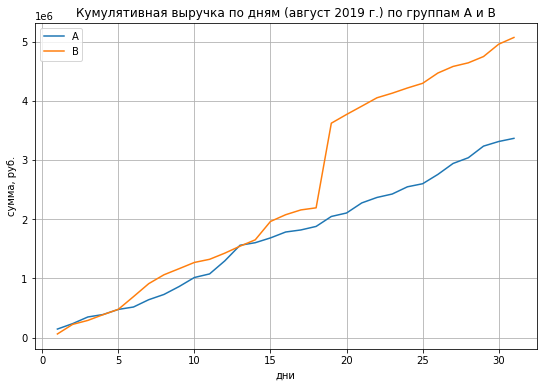

In [28]:
plt.figure(figsize=(9,6))

# Строим график выручки группы А
plt.plot(data['date'].dt.day, data['revenueCummulativeA'])

# Строим график выручки группы B
plt.plot(data['date'].dt.day, data['revenueCummulativeB'])

plt.grid(True)
plt.title('Кумулятивная выручка по дням (август 2019 г.) по группам А и В')
plt.legend(['A','B'])
plt.xlabel('дни')
plt.ylabel('сумма, руб.')
plt.show()

Выручка довольно равномерно увеличивается в течение всего теста. Однако график группы В имеет резкий скачок - это может быть точечное увеличение числа заказов или очень дорогие заказы.

## Построим график кумулятивного среднего чека по группам

Разделим кумулятивную выручку на кумулятивное число заказов:

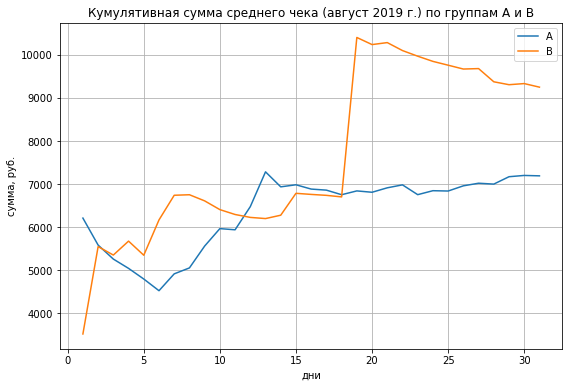

In [29]:
plt.figure(figsize=(9,6))

plt.plot(
    data['date'].dt.day,
    data['revenueCummulativeA']/data['ordersCummulativeA'])
plt.plot(
    data['date'].dt.day,
    data['revenueCummulativeB']/data['ordersCummulativeB'])

plt.grid(True)
plt.title('Кумулятивная сумма среднего чека (август 2019 г.) по группам А и В')
plt.legend(['A','B'])
plt.xlabel('дни')
plt.ylabel('сумма, руб.')
plt.show()

Средний чек в группе А становится более равномерным ближе к концу теста. Для группы В имеется резкий всплеск (увеличение числа заказов или крупные заказы) во второй половине и последующее его снижение. Вероятно нужно больше данных, чтобы прийти к реальному среднему чеку.

## Построим график относительного изменения кумулятивного среднего чека группы B к группе A

Построим график относительного различия для среднего чека и добавим горизонтальную ось:

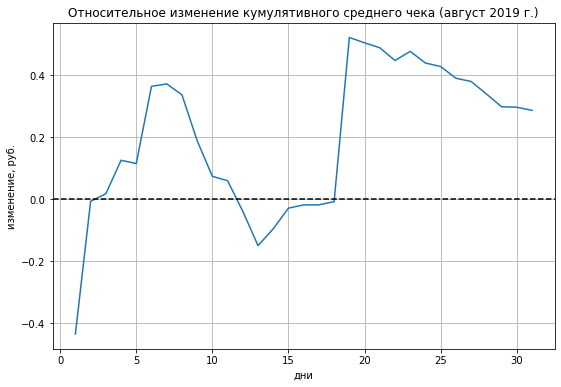

In [30]:
plt.figure(figsize=(9,6))

# cтроим отношение кумулятивного среднего чека по дням группы B к группе A
plt.plot(data['date'].dt.day,
    (data['revenueCummulativeB']/data['ordersCummulativeB'])
    /(data['revenueCummulativeA']/data['ordersCummulativeA'])-1
)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.grid(True)
plt.title('Относительное изменение кумулятивного среднего чека (август 2019 г.)')
plt.xlabel('дни')
plt.ylabel('изменение, руб.')
plt.show()

В нескольких точках график различия между сегментами резко «скачет» - это говорит о том, что присутствуют крупные заказы - выбросы.

## Построим график кумулятивной конверсии по группам

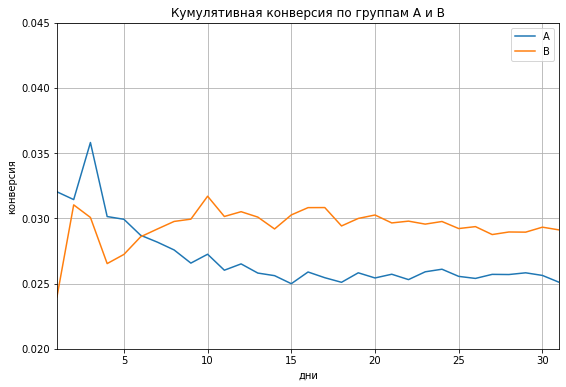

In [31]:
plt.figure(figsize=(9,6))

# строим графики
plt.plot(data['date'].dt.day,
         data['ordersCummulativeA']/data['visitorsCummulativeA']
)
plt.plot(data['date'].dt.day,
         data['ordersCummulativeB']/data['visitorsCummulativeB']
)

plt.grid(True)
plt.title('Кумулятивная конверсия по группам А и В')
plt.legend(['A','B'])
plt.xlabel('дни')
plt.ylabel('конверсия')
plt.axis([1,31,0.02,0.045])
plt.show()

Первую неделю группы колебались около одного значения, но затем конверсия группы В стала выше и стабилизировалась, а конверсия группы А, наоборот, просела и также стабилизировалась.

## Построим график относительного изменения кумулятивной конверсии группы B к группе A.

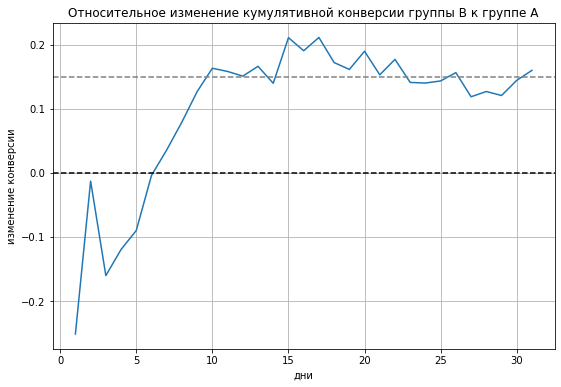

In [32]:
plt.figure(figsize=(9,6))

plt.plot(
    data['date'].dt.day,
    (data['ordersCummulativeB']/data['visitorsCummulativeB']) /
    (data['ordersCummulativeA']/data['visitorsCummulativeA']) - 1)
plt.grid(True)
plt.title('Относительное изменение кумулятивной конверсии группы В к группе А')
plt.xlabel('дни')
plt.ylabel('изменение конверсии')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.show()

Спустя примерно неделю с начала теста группа В стала расти и лидировать по конверсии. После чего через две недели конверсия немного снизилась и, похоже, стабилизировалась в приросте около 10-15% относительно граппы А.

## Построим точечный график количества заказов по пользователям

Число заказов по пользователям:

In [33]:
ordersByUsers = (
    orders
    .groupby('visitorId', as_index=False)
    .agg({'transactionId' : 'nunique',})
)

ordersByUsers.columns = ['visitorId', 'transactionId']

display(ordersByUsers.sort_values(by='transactionId', ascending=False).head(5))

,visitorId,transactionId
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


Построим диаграмму методом scatter()

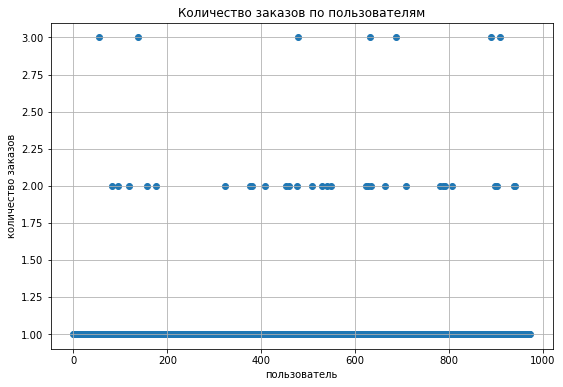

In [34]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(9, 6))
plt.scatter(x_values, ordersByUsers['transactionId'])
plt.grid(True)
plt.title('Количество заказов по пользователям')
plt.xlabel('пользователь')
plt.ylabel('количество заказов')
plt.show()

Пользователей, заказавших более двух раз, совсем мало.<br>
Они вполне могут быть аномальными.

In [35]:
ordersByUsers = (
    orders
    .groupby(['visitorId','group'], as_index=False)
    .agg({'transactionId' : 'nunique',})
)

display(ordersByUsers.sort_values(by='transactionId', ascending=False).head(4))

,visitorId,group,transactionId
908,3967698036,A,3
55,249864742,B,3
478,2108163459,A,3
687,2988190573,A,3


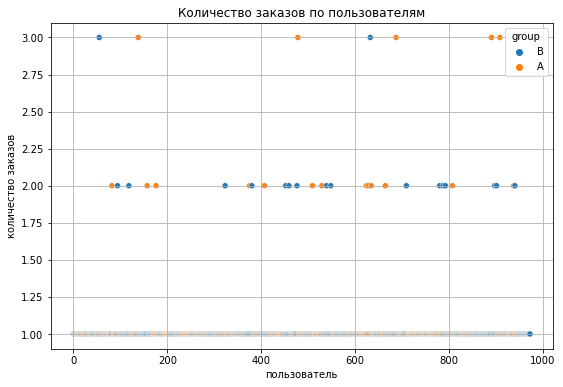

In [36]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(9, 6))
# plt.scatter(x_values, ordersByUsers['transactionId'], hue=['group'])
sns.scatterplot(data=ordersByUsers, x = x_values, y='transactionId', hue='group')
plt.grid(True)
plt.title('Количество заказов по пользователям')
plt.xlabel('пользователь')
plt.ylabel('количество заказов')
plt.show()

## Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [37]:
display(ordersByUsers.sort_values(by='transactionId', ascending=False).head(5))

print(np.percentile(ordersByUsers['transactionId'], [95, 99]))

,visitorId,group,transactionId
908,3967698036,A,3
55,249864742,B,3
478,2108163459,A,3
687,2988190573,A,3
890,3908431265,A,3


[1. 2.]


Не более 5% пользователей совершали больше двух заказов.<br>
И не более 1% пользователей - больше четырёх заказов.

## Построем точечный график стоимостей заказов

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500.0,B
1196,3936777065,2108080724,2019-08-15,202740.0,B
1136,666610489,1307669133,2019-08-13,92550.0,A
744,3668308183,888512513,2019-08-27,86620.0,B
743,3603576309,4133034833,2019-08-09,67990.0,A


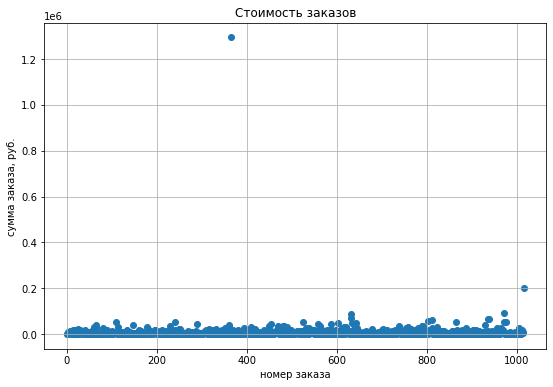

In [38]:
display(orders.sort_values(by='revenue', ascending=False).head(5))

x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(9, 6))
plt.scatter(x_values, orders['revenue'])
plt.grid(True)
plt.title('Стоимость заказов')
plt.xlabel('номер заказа')
plt.ylabel('сумма заказа, руб.')
plt.show()

В основном все заказы стоят не более 200 000 руб., а больше кажется всего два: один около 200 000 руб., а второй около 1,3 млн. руб. - выглядит весьма анамально.

## Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [39]:
orders.sort_values(by='revenue', ascending=False).head(3)

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500.0,B
1196,3936777065,2108080724,2019-08-15,202740.0,B
1136,666610489,1307669133,2019-08-13,92550.0,A


In [40]:
print(np.percentile(orders['revenue'], [95, 99, 99.9]))

[ 26785.          53904.         201087.15000001]


Не более, чем у 5% заказов стоимость дороже 28 000.00 рублей,<br>
а не более, чем у 1% заказов стоимость дороже 58 233.20 рублей.

Кроме того, не более, чем у 0,1% заказов стоимость дороже 180 тыс. руб. и туда как раз попадают эти два сверхдорогих заказа.

## Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

Зададим критический уровень значимости и точность отображения p-value:

In [41]:
alpha = 0.05
precision = 3

**Гипотеза:**
- нулевая гипотеза: нет статистически значимых различий в конверсии по дням между группами А и В;<br>
- альтернативная гипотеза: есть статистически значимые различия в конверсии по дням между группами А и В.

In [42]:
setA = data['ordersPerDateA'] / data['visitorsPerDateA']
setB = data['ordersPerDateB'] / data['visitorsPerDateB']

results = st.mannwhitneyu(setA, setB)

print('p-значение: ', round(results.pvalue, precision))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  0.057
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


По "сырым" данным **нет статистически значимых различий в конверсии по дням** между группами A и B.

**Гипотеза:**
- нулевая гипотеза: нет статистически значимых различий в кумулятивной конверсии по дням между группами А и В;<br>
- альтернативная гипотеза: есть статистически значимые различия в кумулятивной конверсии по дням между группами А и В.

In [43]:
setA = data['ordersCummulativeA'] / data['visitorsCummulativeA']
setB = data['ordersCummulativeB'] / data['visitorsCummulativeB']

results = st.mannwhitneyu(setA, setB)

print('p-значение: ', round(results.pvalue, precision+5))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  1.275e-05
Отвергаем нулевую гипотезу: разница статистически значима


По "сырым" данным **есть статистически значимые различия в кумулятивной конверсии по дням** между группами A и B.

## Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Средний чек по группе А:

In [44]:
meanrevenueA = orders[orders['group']=='A']['revenue'].mean()
meanrevenueA

7189.4358974358975

Средний чек по группе В:

In [45]:
meanrevenueB = orders[orders['group']=='B']['revenue'].mean()
meanrevenueB

9249.94890510949

Изменение среднего чека, %:

In [46]:
round((meanrevenueB/meanrevenueA-1)*100, 2)

28.66

**Гипотеза:**
- нулевая гипотеза: нет статистически значимых различий в суммах чеков между группами А и В;<br>
- альтернативная гипотеза: есть статистически значимые различия в суммах чеков между группами А и В.

In [47]:
setA = orders[orders['group']=='A']['revenue']
setB = orders[orders['group']=='B']['revenue']

results = st.mannwhitneyu(setA, setB)

print('p-значение: ', round(results.pvalue, precision))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  0.829
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


По "сырым" данным **нет статистически значимых различий в суммах чеков** между группами А и В.

**Гипотеза:**
- нулевая гипотеза: нет статистически значимых различий в средний чеках по дням между группами А и В;<br>
- альтернативная гипотеза: есть статистически значимые различия в средний чеках по дням между группами А и В.

In [48]:
setA = data['revenuePerDateA'] / data['ordersPerDateA']
setB = data['revenuePerDateB'] / data['ordersPerDateB']

results = st.mannwhitneyu(setA, setB)

print('p-значение: ', round(results.pvalue, precision))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  0.955
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


По "сырым" данным **нет статистически значимых различий в средних чеках по дням** между группами А и В.

**Гипотеза:**
- нулевая гипотеза: нет статистически значимых различий в кумулятивных средних чеках по дням между группами А и В;<br>
- альтернативная гипотеза: есть статистически значимые различия в кумулятивных средних чеках по дням между группами А и В.

In [49]:
setA = data['revenueCummulativeA'] / data['ordersCummulativeA']
setB = data['revenueCummulativeB'] / data['ordersCummulativeB']

results = st.mannwhitneyu(setA, setB)

print('p-значение: ', round(results.pvalue, precision))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  0.159
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


По "сырым" данным **нет статистически значимых различий в кумулятивных средних чеках по дням** между группами А и В.

## Посчитаем статистическую значимость различий в конверсии между группами по "очищенным" данным

In [50]:
print(np.percentile(orders['revenue'], [95, 99, 99.9]))

[ 26785.          53904.         201087.15000001]


Примем за аномальных тех пользователей, которые совершили заказы на сумму 53904 руб. и более, т.е. 1% пользователей.

In [51]:
abnormalVisitors = (
    orders[orders['revenue'] >= np.percentile(orders['revenue'], [99])[0]]
    ['visitorId'].unique()
)
display(
    orders[orders['visitorId'].isin(abnormalVisitors)]
    .groupby(['group']).agg({'revenue':'sum'}).sort_values(by='revenue', ascending=False)
)
display(
    orders[orders['visitorId'].isin(abnormalVisitors)].sort_values(by='revenue', ascending=False)
)

,revenue
group,
B,1696314.0
A,460858.0


,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500.0,B
1196,3936777065,2108080724,2019-08-15,202740.0,B
1136,666610489,1307669133,2019-08-13,92550.0,A
744,3668308183,888512513,2019-08-27,86620.0,B
743,3603576309,4133034833,2019-08-09,67990.0,A
1103,1348774318,1164614297,2019-08-12,66350.0,A
1099,316924019,148427295,2019-08-12,65710.0,A
949,1347999392,887908475,2019-08-21,60450.0,A
940,2420050534,4003628586,2019-08-08,58550.0,B
131,3163614039,2254586615,2019-08-22,53904.0,A


Пользователи с аномально большими суммами заказов по большей части попали в группу В.

Отберем только те заказы, которые не делали аномальные пользователи, т.е. из таблицы orders исключим все заказы, принадлежащие анамальным пользователям.

In [52]:
orders2 = orders[~orders['visitorId'].isin(abnormalVisitors)]
orders2.head(3)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650.0,B
1,2804400009,3642806036,2019-08-15,730.0,B
3,3797467345,1196621759,2019-08-15,9759.0,B


Построим таблицу data2 для "очищенных" данных:

In [53]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders2[orders2['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders2[orders2['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data2 = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data2.head(3))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23         142779.0              17   
1 2019-08-02              19          91602.0              23   
2 2019-08-03              24         112473.0              14   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0          59758.0                  23             142779.0   
1         162043.0                  42             234381.0   
2          67049.0                  66             346854.0   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17              59758.0               718   
1                  40             221801.0               618   
2                  54             288850.0               507   

   visitorsPerDateB  visitorsCummulativeA  visitorsCummulativeB  
0               709                   718                   709  
1               580                  1336                  1289  
2               507            

**Гипотеза:**
- нулевая гипотеза: нет статистически значимых различий в конверсии по дням между группами А и В;<br>
- альтернативная гипотеза: есть статистически значимые различия в конверсии по дням между группами А и В.

In [54]:
setA = data2['ordersPerDateA'] / data2['visitorsPerDateA']
setB = data2['ordersPerDateB'] / data2['visitorsPerDateB']

results = st.mannwhitneyu(setA, setB)

print('p-значение: ', round(results.pvalue, precision))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  0.043
Отвергаем нулевую гипотезу: разница статистически значима


По "очищенным" данным **есть статистически значимое различие в конверсии по дням** между группами А и В.

**Гипотеза:**
- нулевая гипотеза: нет статистически значимых различий в кумулятивной конверсии по дням между группами А и В;<br>
- альтернативная гипотеза: есть статистически значимые различия в кумулятивной конверсии по дням между группами А и В.

In [55]:
setA = data2['ordersCummulativeA']/data2['visitorsCummulativeA']
setB = data2['ordersCummulativeB']/data2['visitorsCummulativeB']

results = st.mannwhitneyu(setA, setB)

print('p-значение: ', round(results.pvalue, precision+8))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  2.404604e-05
Отвергаем нулевую гипотезу: разница статистически значима


По "очищенным" данным **есть статистически значимое различие в кумулятивной конверсии по дням** между группами А и В.

## Посчитаем статистическую значимость различий в среднем чеке заказа между группами по "очищенным" данным

Средний чек по группе А:

In [56]:
meanrevenueA = orders2[orders2['group']=='A']['revenue'].mean()
meanrevenueA

6298.9110629067245

Средний чек по группе В:

In [57]:
meanrevenueB = orders2[orders2['group']=='B']['revenue'].mean()
meanrevenueB

6211.156537753222

Изменение среднего чека, %:

In [58]:
round((meanrevenueB/meanrevenueA-1)*100, 2)

-1.39

**Гипотеза:**
- нулевая гипотеза: нет статистически значимых различий в суммах чеков между группами А и В;<br>
- альтернативная гипотеза: есть статистически значимые различия в суммах чеков между группами А и В.

In [59]:
setA = orders2[orders2['group']=='A']['revenue']
setB = orders2[orders2['group']=='B']['revenue']

results = st.mannwhitneyu(setA, setB)

print('p-значение: ', round(results.pvalue, precision))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  0.954
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


По "очищенным" данным **нет статистически значимых различий в суммах чеков** между группами А и В.

Средний чек по всей группе В больше на 2% среднего чека по всей группе А.

**Гипотеза:**
- нулевая гипотеза: нет статистически значимых различий в средних чеках по дням между группами А и В;<br>
- альтернативная гипотеза: есть статистически значимые различия в средних чеках по дням между группами А и В.

In [60]:
setA = data2['revenuePerDateA'] / data2['ordersPerDateA']
setB = data2['revenuePerDateB'] / data2['ordersPerDateB']

results = st.mannwhitneyu(setA, setB)

print('p-значение: ', round(results.pvalue, precision))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  0.978
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


По "очищенным" данным **нет статистически значимых различий в средних чеках по дням** между группами А и В.

**Гипотеза:**
- нулевая гипотеза: нет статистически значимых различий в кумулятивных средних чеках по дням между группами А и В;<br>
- альтернативная гипотеза: есть статистически значимые различия в кумулятивных средних чеках по дням между группами А и В.

In [61]:
setA = data2['revenueCummulativeA'] / data2['ordersCummulativeA']
setB = data2['revenueCummulativeB'] / data2['ordersCummulativeB']

results = st.mannwhitneyu(setA, setB)

print('p-значение: ', round(results.pvalue, precision+7))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  0.0359309954
Отвергаем нулевую гипотезу: разница статистически значима


По "очищенным" данным **есть статистически значимое различие в кумулятивных средних чеках по дням** между группами А и В.

## Решение по результатам теста

По "сырым" данным выявлены статистически значимые различия между группами А и В в случае конверсии с накоплением по дням, а по среднему чеку с накоплением по дням статистически значимых различий нет. Средний чек по всем заказам группы В оказался значительно больше (на 28.7%), чем группы А.

На графике кумулятивной выручки по дням есть резкий скачок, что является результатом появления аномально крупных заказов. Этот же скачок отлично виден и на графике кумулятивного среднего чека, а также резкие скачки на графике относительного изменения укмулятивного среднего чека. По графику стоимости заказов также видно, что выбросы есть, но их не так уж много. Выбрав 1% самых больших по стоимости заказов как границу аномальных заказов, очистили данные от заказов тех пользователей, которые сделали эти аномально дорогие заказы.

После чего по "очищенным" данным также были выявлены статистически значимые различия между группами А и В в обоих случаях: и по конверсии с накоплением по дням и по среднему чеку с накоплением по дням. Средний чек в случае "очищенных" данных по всем заказам группы В оказался меньше, чем группы А на 1.4%.

*Исходя того, что группа В статистически значимо лучше группы А по конверсии и по среднему чеку как для "сырых" так и для "очищенных" данных ***можно остановить тест и признать победу группы В***.*

